In [1]:
import sys
sys.path.append('../')

In [2]:
import libs.db
import libs.prep_df
import pandas as pd
import sqlite3

In [3]:
sql_file = "sp10_historical.db"
conn = libs.db.create_connection(sql_file)
hist_df = libs.db.df_from_db(conn)
libs.db.close_connection(conn)
hist_df.head()

,id,symbol,timestamp,close
0,1,AAPL,2017-01-03T09:00:00+00:00,116.05
1,2,AAPL,2017-01-03T10:00:00+00:00,116.02
2,3,AAPL,2017-01-03T11:00:00+00:00,116.28
3,4,AAPL,2017-01-03T12:00:00+00:00,116.02
4,5,AAPL,2017-01-03T13:00:00+00:00,116.20


In [4]:
hist_df = libs.prep_df.normalize_df(hist_df)
hist_df.head()

symbol,AAPL,AMZN,BRK.B,FB,GOOGL,JNJ,JPM,MSFT,NVDA,TSLA
timestamp,,,,,,,,,,
2017-01-03 09:00:00+00:00,116.05,757.76,164.50,116.30,800.1,115.30,86.98,62.65,108.00,214.03
2017-01-03 10:00:00+00:00,116.02,757.84,164.50,116.16,800.0,115.65,86.98,62.65,108.04,214.03
2017-01-03 11:00:00+00:00,116.28,759.00,164.90,116.45,801.0,115.65,87.23,62.80,108.00,214.91
2017-01-03 12:00:00+00:00,116.02,759.30,164.53,116.15,800.0,115.65,87.25,62.80,108.84,215.55
2017-01-03 13:00:00+00:00,116.20,757.40,164.15,116.10,800.0,115.89,87.20,62.55,105.32,215.51


In [5]:
tickers = libs.db.get_tickers("sp10.csv")
print(tickers)

['AAPL', 'MSFT', 'AMZN', 'FB', 'GOOGL', 'TSLA', 'BRK.B', 'NVDA', 'JPM', 'JNJ']


In [6]:
num_ticks = 60
hist_shifted_df = pd.DataFrame()
for ticker in tickers:
    hist_shifted_df[ticker] = hist_df[ticker].copy()
    for i in range(1,num_ticks):
        name = f"{ticker}-{i}"
        hist_shifted_df[name] = hist_df[ticker].shift(i)
hist_shifted_df = hist_shifted_df.copy()
hist_shifted_df.shape

ipykernel_launcher:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
ipykernel_launcher:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


(17080, 600)

In [7]:
#This function performs a pct_change on the hourly price data over a 16 row period.  The data from alpaca provides 16 hours of data for a 24-hour period, so this is the 24 hour return.
# It then shifts the pct_change back 16 rows so that the forward 24-hour return sits on the same timestamp as the current price.

hist_pct_returns_df_list = []
for ticker in tickers:
    name = f"{ticker}_24_Return"
    returns_df = pd.DataFrame()
    returns_df[name] = hist_df[ticker].pct_change(periods=16).shift(-16)
    hist_pct_returns_df_list.append(returns_df)
len(hist_pct_returns_df_list)

10

In [8]:
sql_file = "sp10_current.db"
conn = libs.db.create_connection(sql_file)
current_df = libs.db.df_from_db(conn)
libs.db.close_connection(conn)
current_df.head()

,id,symbol,timestamp,close
0,1,AAPL,2021-06-01T08:00:00+00:00,125.25
1,2,AAPL,2021-06-01T09:00:00+00:00,125.27
2,3,AAPL,2021-06-01T10:00:00+00:00,125.25
3,4,AAPL,2021-06-01T11:00:00+00:00,125.12
4,5,AAPL,2021-06-01T12:00:00+00:00,125.12


In [9]:
current_df = libs.prep_df.normalize_df(current_df)
current_df.head()

symbol,AAPL,AMZN,BRK.B,FB,GOOGL,JNJ,JPM,MSFT,NVDA,TSLA
timestamp,,,,,,,,,,
2021-06-01 08:00:00+00:00,125.25,3238.00,290.90,329.30,2367.5,169.95,164.48,251.35,654.50,628.90
2021-06-01 09:00:00+00:00,125.27,3241.00,290.88,329.51,2367.5,169.95,164.48,251.29,654.99,631.14
2021-06-01 10:00:00+00:00,125.25,3241.00,291.44,329.30,2367.5,169.95,164.48,250.60,654.25,630.95
2021-06-01 11:00:00+00:00,125.12,3236.52,291.70,329.56,2367.5,169.95,165.30,250.70,653.50,629.70
2021-06-01 12:00:00+00:00,125.12,3238.00,291.50,329.40,2369.0,169.61,165.74,250.26,651.10,627.45


In [10]:
current_shifted_df = pd.DataFrame()
for ticker in tickers:
    current_shifted_df[ticker] = current_df[ticker].copy()
    for i in range(1,num_ticks):
        name = f"{ticker}-{i}"
        current_shifted_df[name] = current_df[ticker].shift(i)
current_shifted_df = current_shifted_df.copy()
current_shifted_df.dropna(inplace=True)
current_shifted_df.head()

ipykernel_launcher:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
ipykernel_launcher:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


,AAPL,AAPL-1,AAPL-2,AAPL-3,AAPL-4,AAPL-5,AAPL-6,AAPL-7,AAPL-8,AAPL-9,...,JNJ-50,JNJ-51,JNJ-52,JNJ-53,JNJ-54,JNJ-55,JNJ-56,JNJ-57,JNJ-58,JNJ-59
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-06-04 19:00:00+00:00,125.88,126.0547,125.6800,125.6499,125.1000,124.9699,124.9250,124.1500,123.9800,123.7000,...,166.090,165.850,166.280,166.245,167.465,169.610,169.950,169.950,169.950,169.95
2021-06-04 20:00:00+00:00,125.98,125.8800,126.0547,125.6800,125.6499,125.1000,124.9699,124.9250,124.1500,123.9800,...,166.195,166.090,165.850,166.280,166.245,167.465,169.610,169.950,169.950,169.95
2021-06-04 21:00:00+00:00,125.99,125.9800,125.8800,126.0547,125.6800,125.6499,125.1000,124.9699,124.9250,124.1500,...,165.470,166.195,166.090,165.850,166.280,166.245,167.465,169.610,169.950,169.95
2021-06-04 22:00:00+00:00,125.95,125.9900,125.9800,125.8800,126.0547,125.6800,125.6499,125.1000,124.9699,124.9250,...,165.380,165.470,166.195,166.090,165.850,166.280,166.245,167.465,169.610,169.95
2021-06-04 23:00:00+00:00,126.01,125.9500,125.9900,125.9800,125.8800,126.0547,125.6800,125.6499,125.1000,124.9699,...,165.250,165.380,165.470,166.195,166.090,165.850,166.280,166.245,167.465,169.61


In [11]:
hist_pctchange_df = hist_shifted_df.pct_change()
hist_pctchange_df = pd.concat([hist_pctchange_df, *hist_pct_returns_df_list], axis=1)
hist_pctchange_df.dropna(inplace=True)
hist_pctchange_df.shape

(17004, 610)

In [30]:
current_pctchange_df = current_shifted_df.pct_change()
current_pctchange_df.dropna(inplace=True)
current_pctchange_df.head()

,AAPL,AAPL-1,AAPL-2,AAPL-3,AAPL-4,AAPL-5,AAPL-6,AAPL-7,AAPL-8,AAPL-9,...,JNJ-50,JNJ-51,JNJ-52,JNJ-53,JNJ-54,JNJ-55,JNJ-56,JNJ-57,JNJ-58,JNJ-59
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-06-04 20:00:00+00:00,0.000794,-0.001386,0.002981,0.000240,0.004396,0.001041,0.000359,0.006242,0.001371,0.002264,...,0.000632,0.001447,-0.002586,0.000211,-0.007285,-0.012647,-0.002001,0.000000,0.000000,0.000000
2021-06-04 21:00:00+00:00,0.000079,0.000794,-0.001386,0.002981,0.000240,0.004396,0.001041,0.000359,0.006242,0.001371,...,-0.004362,0.000632,0.001447,-0.002586,0.000211,-0.007285,-0.012647,-0.002001,0.000000,0.000000
2021-06-04 22:00:00+00:00,-0.000317,0.000079,0.000794,-0.001386,0.002981,0.000240,0.004396,0.001041,0.000359,0.006242,...,-0.000544,-0.004362,0.000632,0.001447,-0.002586,0.000211,-0.007285,-0.012647,-0.002001,0.000000
2021-06-04 23:00:00+00:00,0.000476,-0.000317,0.000079,0.000794,-0.001386,0.002981,0.000240,0.004396,0.001041,0.000359,...,-0.000786,-0.000544,-0.004362,0.000632,0.001447,-0.002586,0.000211,-0.007285,-0.012647,-0.002001
2021-06-07 08:00:00+00:00,-0.005158,0.000476,-0.000317,0.000079,0.000794,-0.001386,0.002981,0.000240,0.004396,0.001041,...,0.001210,-0.000786,-0.000544,-0.004362,0.000632,0.001447,-0.002586,0.000211,-0.007285,-0.012647


In [12]:
y_start = len(tickers)*num_ticks

In [23]:
from sklearn.linear_model import LinearRegression
X = hist_pctchange_df.iloc[:,0:y_start].values
y = []
for i in range(0,len(tickers)):
    y.append(hist_pctchange_df.iloc[:,y_start+i].values)
lin_models = []
y_lin_predicted = []

In [24]:
for i in range(0,len(tickers)):
    ticker = tickers[i]
    model = LinearRegression()
    model.fit(X,y[i])
    lin_models.append(model)
    predicted = model.predict(X)
    y_lin_predicted.append(predicted)
    
    

In [25]:
from sklearn.metrics import r2_score
import numpy as np
r2 = [0]*len(tickers)
for i in range(0,len(tickers)):
    r2[i] = r2_score(y[i], y_lin_predicted[i])
    print(f"The r2 score for symbol {tickers[i]} is {r2[i]}")


The r2 score for symbol AAPL is 0.06463483383845314
The r2 score for symbol MSFT is 0.12854732111281575
The r2 score for symbol AMZN is 0.7134600667816808
The r2 score for symbol FB is 0.06340113586833651
The r2 score for symbol GOOGL is 0.07360604961932538
The r2 score for symbol TSLA is 0.0583069087544682
The r2 score for symbol BRK.B is 0.07914818434863213
The r2 score for symbol NVDA is 0.07267750297508213
The r2 score for symbol JPM is 0.0843572843674334
The r2 score for symbol JNJ is 0.07863815863089396


In [31]:
y_current_predicted = []
X = current_pctchange_df.values
for i in range(0,len(tickers)):
    ticker = tickers[i]
    model = lin_models[i]
    predicted = model.predict(X)
    y_current_predicted.append(predicted)


In [76]:
aapl_return = pd.DataFrame({"timestamp":current_pctchange_df.index, "predicted pct_change":y_current_predicted[0]})
aapl_return["buy"] = aapl_return["predicted pct_change"].apply(lambda x: 1 if x >= 0.0075 else 0)
aapl_return = aapl_return.set_index("timestamp")
aapl_return = aapl_return.merge(current_df["AAPL"], how="left", on="timestamp")

timestamp
2021-06-04 20:00:00+00:00    0
2021-06-04 21:00:00+00:00    0
2021-06-04 22:00:00+00:00    0
2021-06-04 23:00:00+00:00    0
2021-06-07 08:00:00+00:00    0
                            ..
2021-06-30 19:00:00+00:00    0
2021-06-30 20:00:00+00:00    0
2021-06-30 21:00:00+00:00    0
2021-06-30 22:00:00+00:00    0
2021-06-30 23:00:00+00:00    0
Name: buy, Length: 292, dtype: int64

In [73]:
aapl_return[aapl_return["buy"] == 1].head(20)

,predicted pct_change,buy,AAPL
timestamp,,,
2021-06-18 10:00:00+00:00,0.008483,1,131.9400
2021-06-18 11:00:00+00:00,0.010951,1,131.5500
2021-06-18 12:00:00+00:00,0.011553,1,131.1400
2021-06-18 13:00:00+00:00,0.014330,1,131.2300
2021-06-18 14:00:00+00:00,0.016120,1,130.7300
2021-06-18 15:00:00+00:00,0.013028,1,130.6900
2021-06-18 16:00:00+00:00,0.014698,1,130.9500
2021-06-18 17:00:00+00:00,0.013948,1,130.9150
2021-06-18 18:00:00+00:00,0.013733,1,130.8075


In [82]:
money = 10000
num_shares = 0
state = 0
buy_index = 0
money_list = []

for i in range(0,len(aapl_return)):
    if state == 1 and i == buy_index + 16:
        #sell
        price = aapl_return.iloc[i,2]
        money = num_shares * price
        state = 0
        print("sell", i ,price)

    if aapl_return.iloc[i,1] == 1 and state == 0 and i < len(aapl_return) - 16:
        #buy
        price = aapl_return.iloc[i,2]
        num_shares = money / price
        buy_index = i
        state = 1
        print("buy", i, price)

    if aapl_return.iloc[i,1] == 1 and state == 1 and i < len(aapl_return) - 16:
        buy_index = i

    if state == 0 :
        money_list.append(money)
    else:
        price = aapl_return.iloc[i,2]
        money_list.append(num_shares*price)
    
aapl_return["ROI"] = money_list

print(money)

buy 150 131.94
sell 180 131.65
9978.02031226315


In [83]:
aapl_return

,predicted pct_change,buy,AAPL,ROI
timestamp,,,,
2021-06-04 20:00:00+00:00,0.007091,0,125.98,10000.000000
2021-06-04 21:00:00+00:00,0.007336,0,125.99,10000.000000
2021-06-04 22:00:00+00:00,0.005382,0,125.95,10000.000000
2021-06-04 23:00:00+00:00,0.000864,0,126.01,10000.000000
2021-06-07 08:00:00+00:00,0.000302,0,125.36,10000.000000
...,...,...,...,...
2021-06-30 19:00:00+00:00,-0.006453,0,136.92,9978.020312
2021-06-30 20:00:00+00:00,-0.006402,0,136.93,9978.020312
2021-06-30 21:00:00+00:00,-0.008819,0,137.02,9978.020312


<AxesSubplot:xlabel='timestamp'>

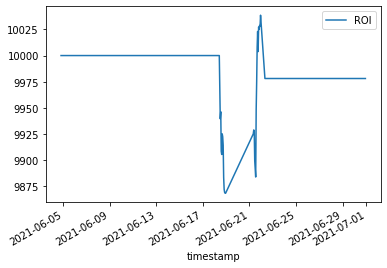

In [85]:
aapl_return.plot(y="ROI")